# Pharmacophores

## Aim of this lab

To understand ligand and structure-based pharacophore modeling.  

### Objectives

* Use RDKit and set of 4 EGFR ligands to create a pharmacophore model.  


## Background


### Pharmacophores

In computer-aided drug design, the description of drug-target interactions with pharmacophores is a well-established method. The term pharmacophore was defined in 1998 by a IUPAC working party:
"A pharmacophore is the ensemble of steric and electronic features that is necessary to ensure the optimal supramolecular interactions with a specific biological target structure and to trigger (or to block) its biological response." 
([<i>Pure & Appl. Chem.</i> (1998), <b>70</b>, 1129-43](https://www.degruyter.com/view/journals/pac/70/5/article-p1129.xml))

In other words, a *pharmacophore* consists of several *pharmacophoric features*, which describe important steric and physico-chemical properties of a ligand observed to bind a target under investigation. 
Such *physico-chemical properties* (also called feature types) can be hydrogen bond donors/acceptors, hydrophobic/aromatic interactions, or positively/negatively charged groups, and the *steric properties* are defined by the 3D arrangement of these features.

### Structure- and ligand-based pharmacophore modeling

In pharmacophore modeling, two main approaches are used, depending on the biological question and available data sources, i.e. structure- and ligand-based pharmacophore modeling.

*Structure-based pharmacophore models* are derived from protein-ligand complexes. Features are defined by observed interactions between the protein and ligand, ensuring that only those ligand moieties are used for virtual screening that have already been shown to be involved in ligand binding. 
However, structures of protein-ligand complexes are not available for all targets. 
In this case, either complex structures can be generated by modeling the ligand into the target binding site, e.g. via molecular docking, or pharmacophore modeling methods can be invoked that only use the target binding site to detect potential protein-ligand interaction sites.

*Ligand-based pharmacophore models* are based on a set of ligands known to bind the target under investigation. The common chemical features of these ligands build the pharmacophore model. This method is used for targets with multiple known ligands and in case of missing protein-ligand complex structures. In this talktorial, we will use ligand-based pharmacophore modeling using a set of known EGFR ligands.

For more information on pharmacophore modeling, we recommend [Pharmacophore Perception and Applications: Applied Chemoinformatics, Wiley-VCH Verlag GmbH & Co. KGaA, Weinheim, (2018), **1**, 259-82](https://onlinelibrary.wiley.com/doi/10.1002/9783527806539.ch6f) and [<i>J. Chem. Inf. Model.</i> (2005), <b>45</b>, 160-9](http://pubs.acs.org/doi/pdf/10.1021/ci049885e).


<img src="img/target+ligand+pharma_3x_feather.png" alt="drawing" width="800"/>

*Figure 1*: Structure-based pharmacophore representing protein-ligand interactions. Figure created by Dominique Sydow.

In [26]:
import collections
from collections import Counter
from pathlib import Path
import operator
import time
import math

import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn import datasets, cluster

from rdkit import RDConfig, Chem, Geometry, DistanceGeometry
from rdkit.Chem import (
    ChemicalFeatures,
    rdDistGeom,
    Draw,
    rdMolTransforms,
    AllChem,
)
from rdkit.Chem.Draw import DrawingOptions
from rdkit.Chem.Pharm3D import Pharmacophore, EmbedLib
from rdkit.Numerics import rdAlignment

### Get pre-aligned ligands

We load the 4 3D-aligned chemicals retrieved from the [Protein Data Bank](https://www.rcsb.org/).

In [27]:
import glob

mol_files = glob.glob("data/*_lig.pdb")
print([f for f in mol_files])

['data/5UGC_lig.pdb', 'data/5UG8_lig.pdb', 'data/5UG9_lig.pdb', 'data/5HG8_lig.pdb']


In [28]:
# get the PDB ids
pdb_ids = [Path(file).stem.split("_")[0] for file in mol_files]
pdb_ids

['5UGC', '5UG8', '5UG9', '5HG8']

Second, we read all ligands from these PDB files using RDKit.

In [29]:
molecules = []
for mol_file in mol_files:
    molecule = Chem.MolFromPDBFile(str(mol_file), removeHs=False)
    if molecule is None:
        print(mol_file, "Could not be read")
    else:
        Chem.SanitizeMol(molecule)
        print(Chem.MolToSmiles(molecule))
        molecules.append(molecule)
print(f"Number of molecules: {len(molecules)}")

CCC(O)NC1CN(C2NC(NC3CN(C)NC3OC)C3NCN(C)C3N2)CC1F
CCC(O)NC1CN(C2NC(NC3CNN(C)C3)C3NCN(C(C)C)C3N2)CC1F
CCC(O)NC1CN(C2NC(NC3CN(C)NC3OC)C3NCN(C(C)C)C3N2)CC1F
CCC(O)NC1CCCC(OC2NC(NC3CNN(C)C3)NC3NCCC32)C1
Number of molecules: 4


The 3D dimension is depicted in 2Ds so the structures our quite ugly, but we can see they are aligned.

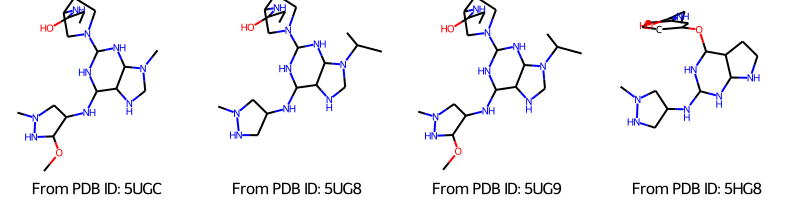

In [30]:
Draw.MolsToGridImage(
    molecules,
    molsPerRow=4,
    legends=[f"From PDB ID: {pdb_id}" for pdb_id in pdb_ids],
)

We can view each individually in 3D using `py3Dmol`

In [31]:
import py3Dmol

In [32]:
mb = Chem.MolToMolBlock(molecules[0])
p = py3Dmol.view(width=400,height=400)
p.addModel(mb,'sdf')
p.setStyle({'stick':{}})
p.setBackgroundColor('white')
p.zoomTo()
p.show()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

The SMILES strings for these ligands has been prepared for you in a file called `data/PDB_top_ligands.csv`.  We need match the SMILES with the correct aligned structures.  Ligands taken from the PDB files do not contain bond information, which we could get from the SMILES strings. 

In [33]:
# Load SMILES for PDB ligand structures
ligands = pd.read_csv("data/PDB_top_ligands.csv")

# Get SMILES in the same order as in pdb_ids
ligand_smiles = [
    ligands[ligands["@structureId"] == pdb_id]["smiles"].values[0] for pdb_id in pdb_ids
]

# Generate RDKit Mol object from SMILES
reference_molecules = [Chem.MolFromSmiles(smiles) for smiles in ligand_smiles]

# Assign bond orders to molecules based on SMILES patterns of reference molecules
molecules = [
    AllChem.AssignBondOrdersFromTemplate(reference_molecule, molecule)
    for reference_molecule, molecule in zip(reference_molecules, molecules)
]

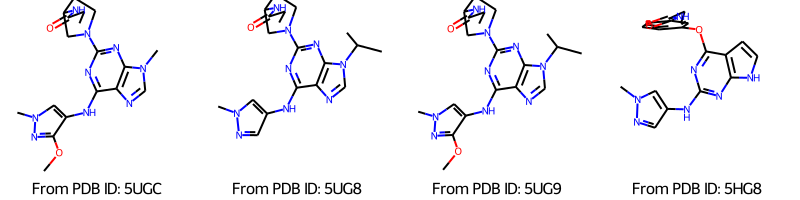

In [34]:
Draw.MolsToGridImage(
    molecules,
    molsPerRow=4,
    legends=[f"From PDB ID: {pdb_id}" for pdb_id in pdb_ids],
)

Now the correct bonds are included.
We can also have a look at the molecules in 2D. In order to keep the original coordinates, we make a copy for the 2D representation.

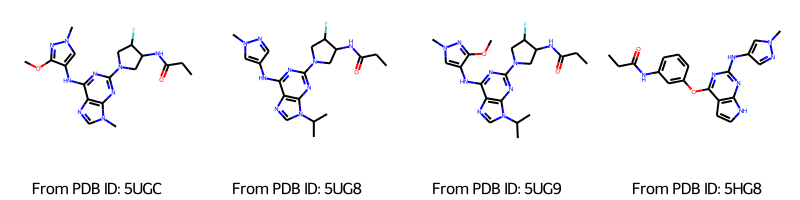

In [35]:
molecules_2d = []
for molecule in molecules:
    tmp = Chem.Mol(molecule)
    AllChem.Compute2DCoords(tmp)
    molecules_2d.append(tmp)
Draw.MolsToGridImage(
    molecules_2d,
    molsPerRow=4,
    legends=[f"From PDB ID: {pdb_id}" for pdb_id in pdb_ids],
)

In [36]:
def show_ligands_3d(molecules):
        
    p = py3Dmol.view(width=400,height=400)
    for mol in molecules:
        mb = Chem.MolToMolBlock(mol)
        p.addModel(mb,'sdf')
        
    p.setStyle({'stick':{}})
    p.setBackgroundColor('white')
    p.zoomTo()
    return p

In [37]:
view = show_ligands_3d(molecules)
view.show()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

### Extract pharmacophore features

As described above, the aim of this talktorial is to generate a ligand-based ensemble pharmacophore from a set of ligands. 
First, we need to extract pharmacophore features per ligand.
Therefore, we load a feature factory. We use the default feature definitions.

See also the [RDKit documentation on chemical features and pharmacophores](https://rdkit.readthedocs.io/en/latest/GettingStartedInPython.html#chemical-features-and-pharmacophores).

In [38]:
feature_factory = AllChem.BuildFeatureFactory(str(Path(RDConfig.RDDataDir) / "BaseFeatures.fdef"))

We take a look at the pharmacophore features that are implemented in RDKit:

In [39]:
list(feature_factory.GetFeatureDefs().keys())

['Donor.SingleAtomDonor',
 'Acceptor.SingleAtomAcceptor',
 'NegIonizable.AcidicGroup',
 'PosIonizable.BasicGroup',
 'PosIonizable.PosN',
 'PosIonizable.Imidazole',
 'PosIonizable.Guanidine',
 'ZnBinder.ZnBinder1',
 'ZnBinder.ZnBinder2',
 'ZnBinder.ZnBinder3',
 'ZnBinder.ZnBinder4',
 'ZnBinder.ZnBinder5',
 'ZnBinder.ZnBinder6',
 'Aromatic.Arom4',
 'Aromatic.Arom5',
 'Aromatic.Arom6',
 'Aromatic.Arom7',
 'Aromatic.Arom8',
 'Hydrophobe.ThreeWayAttach',
 'Hydrophobe.ChainTwoWayAttach',
 'LumpedHydrophobe.Nitro2',
 'LumpedHydrophobe.RH6_6',
 'LumpedHydrophobe.RH5_5',
 'LumpedHydrophobe.RH4_4',
 'LumpedHydrophobe.RH3_3',
 'LumpedHydrophobe.tButyl',
 'LumpedHydrophobe.iPropyl']

As an example, we extract all features from the first molecule.

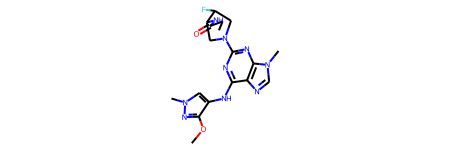

In [40]:
example_molecule = molecules[0]
example_molecule

In [41]:
features = feature_factory.GetFeaturesForMol(example_molecule)
print(f"Number of features found: {len(features)}")

Number of features found: 14


The type of a feature is called family in RDKit and can be retrieved with `GetFamily()`.

In [42]:
features[0].GetFamily()

'Donor'

First we get the frequency of feature types for our example molecule.

In [43]:
feature_frequency = collections.Counter([feature.GetFamily() for feature in features])
feature_frequency

Counter({'Donor': 2,
         'Acceptor': 7,
         'PosIonizable': 1,
         'Aromatic': 3,
         'Hydrophobe': 1})

Now apply the functions shown above to all molecules in our ligand set. 
We calculate the feature type frequency per molecule, then we display it in a DataFrame.

In [44]:
molecule_feature_frequencies = []
for molecule in molecules:
    features = [feature.GetFamily() for feature in feature_factory.GetFeaturesForMol(molecule)]
    feature_frequency = collections.Counter(features)
    molecule_feature_frequencies.append(feature_frequency)

feature_frequencies_df = (
    pd.DataFrame(
        molecule_feature_frequencies,
        index=[f"Mol{i}" for i, _ in enumerate(molecules, 1)],
    )
    .fillna(0)
    .astype(int)
)
feature_frequencies_df.transpose()

,Mol1,Mol2,Mol3,Mol4
Donor,2,2,2,4
Acceptor,7,6,7,5
PosIonizable,1,1,1,0
Aromatic,3,3,3,4
Hydrophobe,1,1,1,2
LumpedHydrophobe,0,1,1,1


In this lab, we will concentrate only on the following feature types: hydrogen bond acceptors (acceptors), hydrogen bond donors (donors), and hydrophobic contacts (hydrophobics).

We retrieve the feature RDKit objects per feature type and per molecule. 

In [45]:
acceptors = []
donors = []
hydrophobics = []

for molecule in molecules:
    acceptors.append(feature_factory.GetFeaturesForMol(molecule, includeOnly="Acceptor"))
    donors.append(feature_factory.GetFeaturesForMol(molecule, includeOnly="Donor"))
    hydrophobics.append(feature_factory.GetFeaturesForMol(molecule, includeOnly="Hydrophobe"))

features = {
    "donors": donors,
    "acceptors": acceptors,
    "hydrophobics": hydrophobics,
}

### Show the pharmacophore features of all ligands

Pharmacophore feature types usually are displayed in defined colors, e.g. usually hydrogen bond donors, hydrogen bond acceptors, and hydrophobic contacts are colored green, red, and yellow, respectively.

In [46]:
feature_colors = {
    "donors": 'green',  # Green
    "acceptors": 'red',  # Red
    "hydrophobics": 'purple',  # Yellow
}

In [47]:
def visualize_features(
    molecules,
    features,
    feature_type="features",
    color="yellow",
    sphere_radius=1,
    linewidth=2,
):

    print(f"Number of {feature_type} in all ligands: {sum([len(i) for i in features])}")
    view = py3Dmol.view(width=400,height=400)
    for mol in molecules:
        mb = Chem.MolToMolBlock(mol)
        view.addModel(mb,'sdf')
        

    for i, feature_set in enumerate(features, 1):
        for feature in feature_set:
            loc = list(feature.GetPos())
            label = f"{feature_type}_{i}"
            view.addSphere({ 'center': {'x':loc[0], 'y':loc[1], 'z':loc[2]}, 
                            'radius': sphere_radius, 
                            'color': color,
                            'linewidth': linewidth,
                            'wireframe': True})

    view.setStyle({'stick':{}})
    view.setBackgroundColor('white')
    view.zoomTo()      
    return view

We use this function to visualize the features for the feature types under consideration.

#### Hydrogen bond donors

In [48]:
feature_type = "donors"
view = visualize_features(
    molecules,
    features[feature_type],
    feature_type,
    feature_colors[feature_type],
)
view.show()

Number of donors in all ligands: 10


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

#### Hydrogen bond acceptors

In [49]:
feature_type = "acceptors"
view = visualize_features(
    molecules,
    features[feature_type],
    feature_type,
    feature_colors[feature_type],
)
view.show()

Number of acceptors in all ligands: 25


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

#### Hydrophobic contacts

In [50]:
feature_type = "hydrophobics"
view = visualize_features(
    molecules,
    features[feature_type],
    feature_type,
    feature_colors[feature_type],
)
view.show()

Number of hydrophobics in all ligands: 5


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol